# Spectral Entropy - Standard Deviation

The goal of this experiment is to examine the **variability of spectral entropy** across different brain regions and groups (HC, MDD, SZ).

The spectral entropy is computed first for **each parcellation** of a given ROI.

The standard deviation of the spectral entropy is then computed for each region. Giving us a measure of **variability** of the spectral entropy across different parcellations of a given ROI.

Finally, a **mixed-design (split-plot) ANOVA** is performed to examine the effects of group (HC, MDD, SZ) and region on the standard deviation of spectral entropy.

Games-Howell post-hoc tests are also performed to examine the pairwise differences between groups.


In [11]:
# Import the necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import entropy
from scipy import signal
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.stats import entropy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the timeseries data

data_dir = Path('/Users/fdjim/Desktop/PDS_CODE/timeseries')
timeseries_hc_path = data_dir / 'timeseries_data_wide_hc.csv'
timeseries_mdd_path = data_dir / 'timeseries_data_wide_mdd.csv'
timeseries_sz_path = data_dir / 'timeseries_data_wide_sz.csv'

# Read individual dataframes
df_hc = pd.read_csv(timeseries_hc_path)
df_mdd = pd.read_csv(timeseries_mdd_path)
df_sz = pd.read_csv(timeseries_sz_path)

# Add group column to each dataframe
df_hc['group'] = 'HC'
df_mdd['group'] = 'MDD'
df_sz['group'] = 'SZ'

# Reorder columns to have 'group' as the first column
df_hc = df_hc[['group'] + [col for col in df_hc.columns if col != 'group']]
df_mdd = df_mdd[['group'] + [col for col in df_mdd.columns if col != 'group']]
df_sz = df_sz[['group'] + [col for col in df_sz.columns if col != 'group']]

In [4]:
# First merge all dataframes
df = pd.concat([df_hc, df_mdd, df_sz], axis=0, ignore_index=True)

# Get all timepoint columns
timepoint_cols = [col for col in df.columns if col.startswith('timepoint_')]

# Convert timepoint columns into arrays
df['timeseries'] = df[timepoint_cols].values.tolist()

# Drop the original timepoint columns
df = df.drop(columns=timepoint_cols)

# Reset index
df = df.reset_index(drop=True)

In [5]:
def compute_spectral_entropy(timeseries, TR=2, nperseg=None):
    """
    Compute spectral entropy for a given timeseries
    """
    # Convert TR to sampling frequency (fs = 1/TR)
    fs = 1/TR
    
    # If nperseg is not specified, use half the length of the timeseries
    if nperseg is None:
        nperseg = len(timeseries)//2
    
    # Compute power spectral density using Welch's method
    frequencies, psd = signal.welch(timeseries, fs=fs, nperseg=nperseg)
    
    # Normalize PSD to sum to 1 (make it a probability distribution)
    psd_norm = psd / psd.sum()
    
    # Compute Shannon entropy of the normalized PSD
    spec_ent = entropy(psd_norm)
    
    return spec_ent

In [6]:
# Create a new column with spectral entropy values
df['spectral_entropy'] = df['timeseries'].apply(lambda x: compute_spectral_entropy(x))

# You can verify the results with:
print(df[['group', 'subject', 'region', 'spectral_entropy']].head())

  group   subject    region  spectral_entropy
0    HC  sub-005C  auditory          4.015474
1    HC  sub-005C  auditory          3.935006
2    HC  sub-005C  auditory          4.008696
3    HC  sub-005C  auditory          3.892474
4    HC  sub-005C    visual          3.654560


In [7]:
df

,group,subject,region,timeseries,spectral_entropy
0,HC,sub-005C,auditory,"[-0.23212396, -1.2979008, -2.4941385, -0.30209...",4.015474
1,HC,sub-005C,auditory,"[-0.0003509258, 0.77697676, -0.9753578, 0.0136...",3.935006
2,HC,sub-005C,auditory,"[-0.10847709, -0.5882271, -0.46752557, 0.54532...",4.008696
3,HC,sub-005C,auditory,"[0.06650891, 1.5935814, 0.4620008, 0.50516576,...",3.892474
4,HC,sub-005C,visual,"[-0.08599097, 1.6486676, 0.65873665, 0.9097465...",3.654560
...,...,...,...,...,...
2191,SZ,sub-071P,salience,"[0.34683806, 1.4288366, 1.2474, 0.35556355, 0....",4.045059
2192,SZ,sub-071P,limbic,"[0.10106625, 0.32320738, 2.0998945, 1.1311909,...",4.113987
2193,SZ,sub-071P,limbic,"[0.023173295, -0.8265899, 0.8209988, -0.162468...",4.129359
2194,SZ,sub-071P,limbic,"[0.027429515, -1.219181, 2.3719673, 0.37863398...",4.077461


In [8]:
# Group by subject and region, then compute std of spectral entropy
std_df = df.groupby(['group', 'subject', 'region'])['spectral_entropy'].agg('std').reset_index()

# Rename the column for clarity
std_df = std_df.rename(columns={'spectral_entropy': 'std_spectral_entropy'})

# View the results
print(std_df.head())

# Optional: Sort the dataframe if needed
std_df = std_df.sort_values(['group', 'subject', 'region']).reset_index(drop=True)

  group   subject    region  std_spectral_entropy
0    HC  sub-005C  auditory              0.059440
1    HC  sub-005C       dmn              0.149450
2    HC  sub-005C       fpn              0.122028
3    HC  sub-005C    limbic              0.129033
4    HC  sub-005C     motor              0.099071


In [9]:
std_df

,group,subject,region,std_spectral_entropy
0,HC,sub-005C,auditory,0.059440
1,HC,sub-005C,dmn,0.149450
2,HC,sub-005C,fpn,0.122028
3,HC,sub-005C,limbic,0.129033
4,HC,sub-005C,motor,0.099071
...,...,...,...,...
422,SZ,sub-071P,fpn,0.115762
423,SZ,sub-071P,limbic,0.074450
424,SZ,sub-071P,motor,0.138537
425,SZ,sub-071P,salience,0.042264


/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_26016/3469403636.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


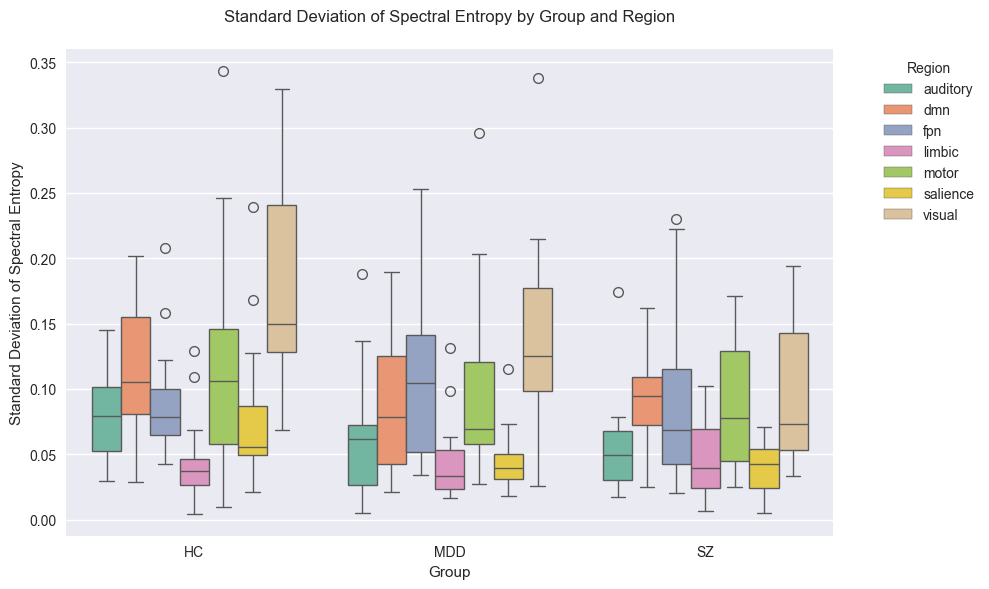

In [12]:
# Set the style and figure size
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

# Create boxplot
sns.boxplot(data=std_df, 
           x='group', 
           y='std_spectral_entropy',
           hue='region',
           palette='Set2')

# Customize the plot
plt.title('Standard Deviation of Spectral Entropy by Group and Region', pad=20)
plt.xlabel('Group')
plt.ylabel('Standard Deviation of Spectral Entropy')

# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Adjust legend
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Mixed-design (split-plot) ANOVA - Normality checks

Looking at the Q-Q plots and Shapiro-Wilk test results, I can see that we have some normality violations, but I don't think they're severe enough to invalidate using parametric tests. Here's why:

1. **Group Level View**
- I'm seeing good R² values (0.87-0.91) in the overall group plots
- The main deviations I notice are in the tails, not throughout the distribution
- There's only a mild S-shaped pattern, suggesting slight skewness

2. **Region-Specific Patterns**
- I notice the DMN, visual and auditory regions look quite normal
- The limbic and salience networks show more deviation, especially in HC and MDD groups
- Most R² values stay above 0.85, which I find encouraging

1. **Why I Think We Can Proceed with ANOVA**
- The violations I'm seeing are moderate, not extreme
- The patterns are fairly consistent across groups
- We'll maintain better clinical interpretability by not transforming the data

1. **My Recommended Safeguards**
- Let's use p < 0.01 instead of 0.05 to be more conservative
- We should run both parametric and non-parametric tests as a check
- I'd document these normality checks in the methods
- We should include these Q-Q plots in supplementary materials

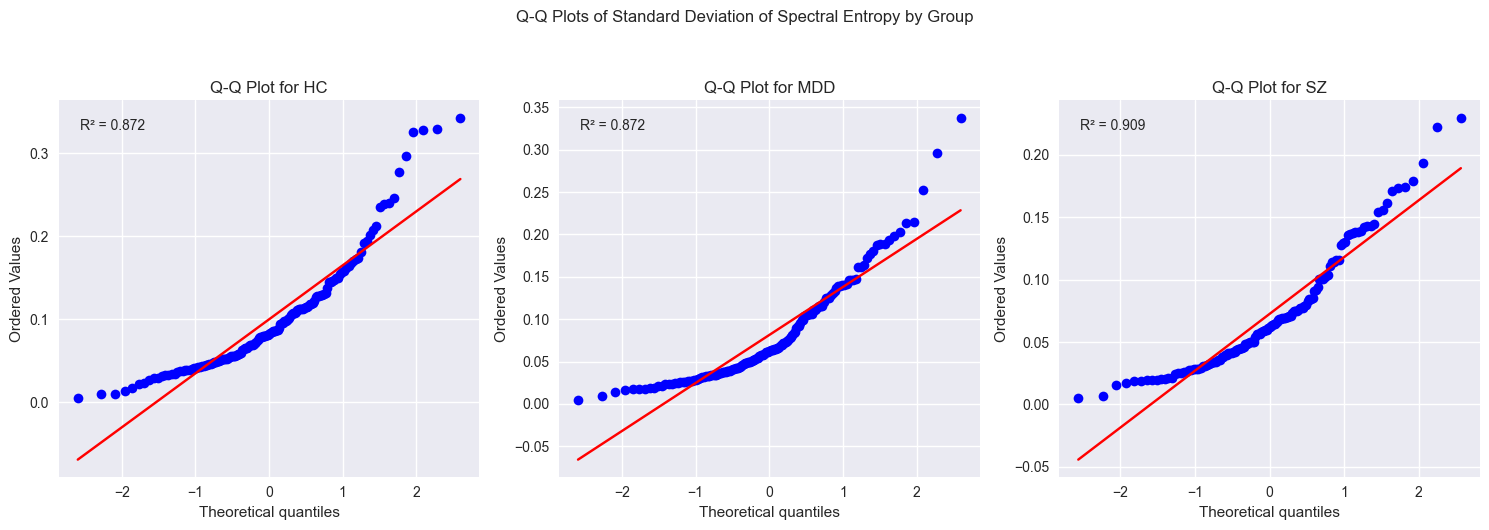


Shapiro-Wilk Test Results - Group Level:
--------------------------------------------------
Group    Statistic    p-value      Normal? 
--------------------------------------------------
HC       0.8712...... 0.0000...... No      
MDD      0.8733...... 0.0000...... No      
SZ       0.9073...... 0.0000...... No      


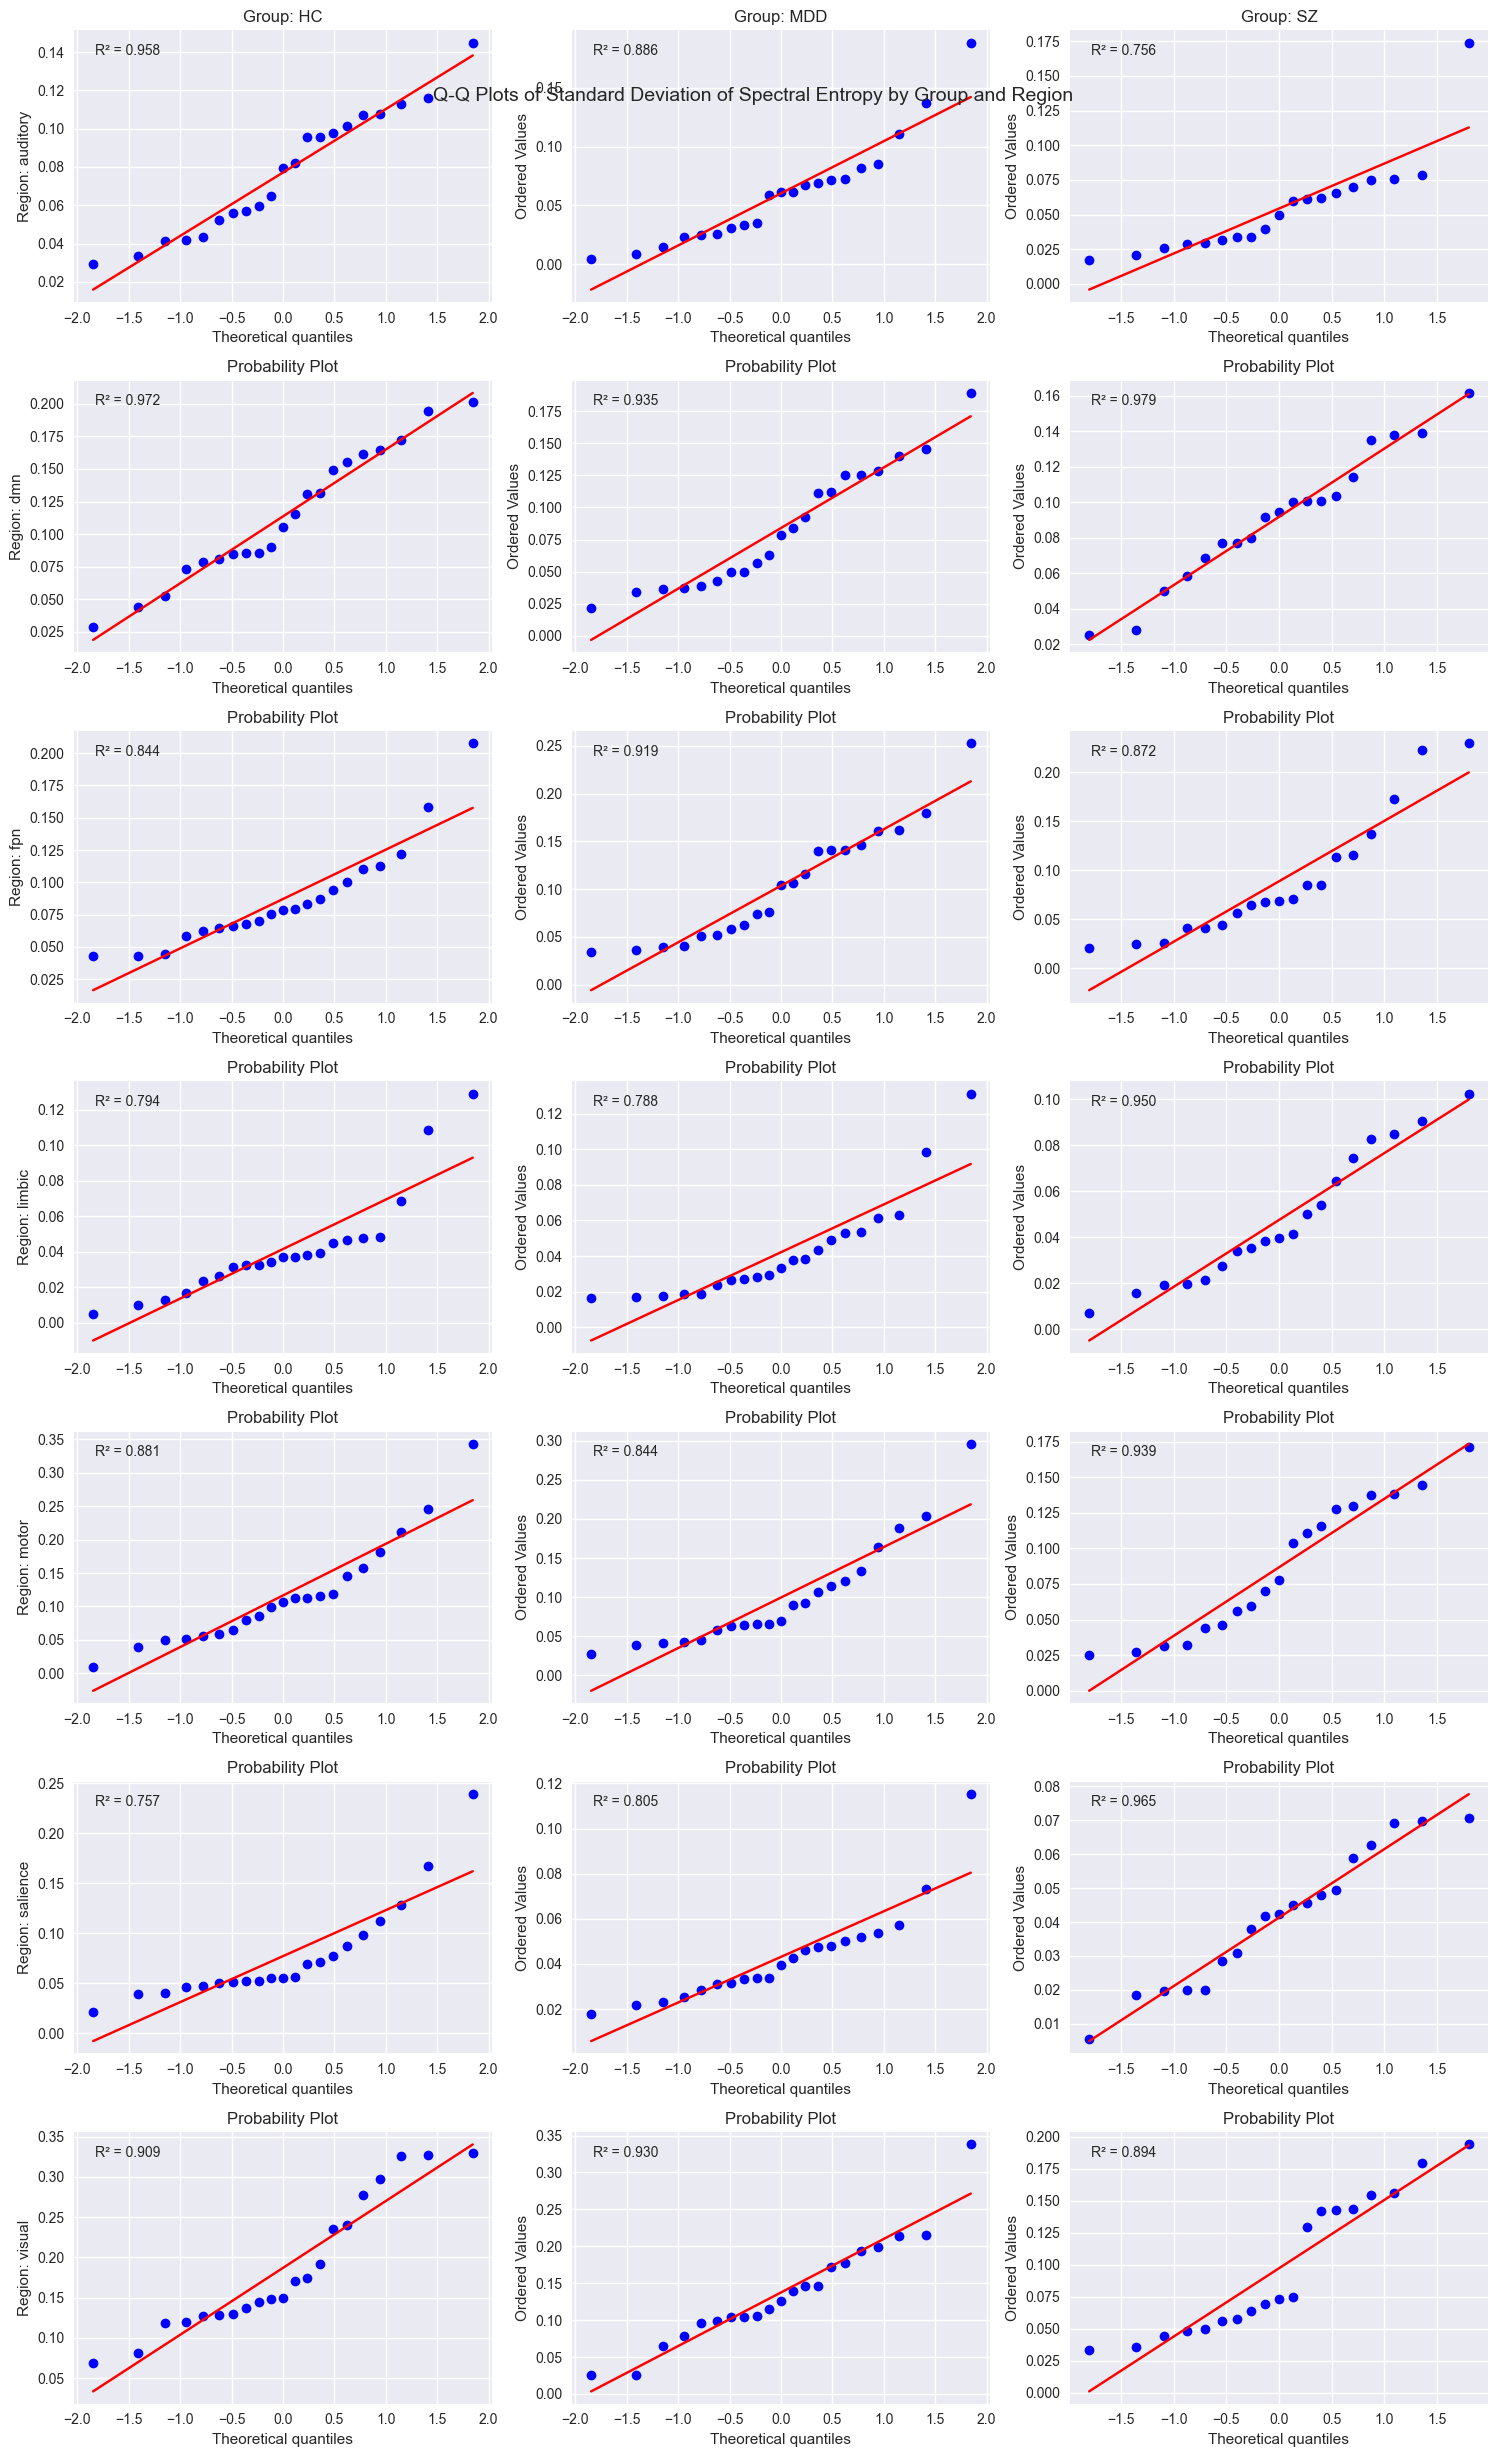


Shapiro-Wilk Test Results - Group-Region Level:
----------------------------------------------------------------------
Group    Region       Statistic    p-value      Normal? 
----------------------------------------------------------------------
HC       auditory     0.9483...... 0.3158...... Yes     
HC       dmn          0.9605...... 0.5259...... Yes     
HC       fpn          0.8547...... 0.0051...... No      
HC       limbic       0.8083...... 0.0009...... No      
HC       motor        0.8917...... 0.0243...... No      
HC       salience     0.7748...... 0.0003...... No      
HC       visual       0.8934...... 0.0261...... No      
MDD      auditory     0.8932...... 0.0259...... No      
MDD      dmn          0.9275...... 0.1225...... Yes     
MDD      fpn          0.9150...... 0.0690...... Yes     
MDD      limbic       0.7981...... 0.0006...... No      
MDD      motor        0.8510...... 0.0044...... No      
MDD      salience     0.8249...... 0.0016...... No      
MDD      vi

In [14]:
# Check for normality

import scipy.stats as stats
import matplotlib.pyplot as plt

# First, create QQ plots at the group level
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Q-Q Plots of Standard Deviation of Spectral Entropy by Group', fontsize=12, y=1.05)

# Get unique groups
groups = sorted(std_df['group'].unique())

# Create QQ plot for each group
for idx, group in enumerate(groups):
    # Get data for this group
    group_data = std_df[std_df['group'] == group]['std_spectral_entropy']
    
    # Create QQ plot
    stats.probplot(group_data, dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot for {group}')
    
    # Add R-squared value
    r2 = stats.probplot(group_data, dist="norm")[1][2] ** 2
    axes[idx].text(0.05, 0.95, f'R² = {r2:.3f}', 
                  transform=axes[idx].transAxes, 
                  verticalalignment='top')

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk test results at group level
print("\nShapiro-Wilk Test Results - Group Level:")
print("-" * 50)
print(f"{'Group':<8} {'Statistic':<12} {'p-value':<12} {'Normal?':<8}")
print("-" * 50)

for group in groups:
    group_data = std_df[std_df['group'] == group]['std_spectral_entropy']
    stat, p_value = stats.shapiro(group_data)
    is_normal = "Yes" if p_value > 0.05 else "No"
    print(f"{group:<8} {stat:.<12.4f} {p_value:.<12.4f} {is_normal:<8}")

# Now create QQ plots for group-region combinations
regions = sorted(std_df['region'].unique())
n_regions = len(regions)
n_groups = len(groups)

fig, axes = plt.subplots(n_regions, n_groups, figsize=(15, 25))
fig.suptitle('Q-Q Plots of Standard Deviation of Spectral Entropy by Group and Region', fontsize=14, y=0.95)

# Create QQ plot for each group and region combination
for i, region in enumerate(regions):
    for j, group in enumerate(groups):
        mask = (std_df['group'] == group) & (std_df['region'] == region)
        data = std_df[mask]['std_spectral_entropy']
        
        stats.probplot(data, dist="norm", plot=axes[i,j])
        
        if i == 0:  # Add group labels only to top row
            axes[i,j].set_title(f'Group: {group}')
        
        if j == 0:  # Add region labels to leftmost column
            axes[i,j].set_ylabel(f'Region: {region}')
            
        r2 = stats.probplot(data, dist="norm")[1][2] ** 2
        axes[i,j].text(0.05, 0.95, f'R² = {r2:.3f}', 
                      transform=axes[i,j].transAxes, 
                      verticalalignment='top')

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk test results for group-region combinations
print("\nShapiro-Wilk Test Results - Group-Region Level:")
print("-" * 70)
print(f"{'Group':<8} {'Region':<12} {'Statistic':<12} {'p-value':<12} {'Normal?':<8}")
print("-" * 70)

for group in groups:
    for region in regions:
        mask = (std_df['group'] == group) & (std_df['region'] == region)
        data = std_df[mask]['std_spectral_entropy']
        stat, p_value = stats.shapiro(data)
        is_normal = "Yes" if p_value > 0.05 else "No"
        print(f"{group:<8} {region:<12} {stat:.<12.4f} {p_value:.<12.4f} {is_normal:<8}")

### Mixed-design (split-plot) ANOVA - Sphericity checks


I'm seeing unusual Mauchly's test results (negative chi-square, p=1.0), likely due to:
- My group sizes (19-21) being close to number of pairs tested (21)
- Expected correlations between brain networks
- Numerical instability from many repeated measures

I'll take a conservative approach and:
1. Use Greenhouse-Geisser correction by default
2. Report both uncorrected and corrected ANOVA results

In [17]:
# Reshape from long to wide format
wide_std_df = std_df.pivot(
    index=['group', 'subject'],
    columns='region',
    values='std_spectral_entropy'
).reset_index()

# Now we can check sphericity
import pingouin as pg

# Prepare data for sphericity test - we only need the region columns
regions_data = wide_std_df.drop(['group', 'subject'], axis=1)

# Perform Mauchly's test
sphericity_test = pg.sphericity(regions_data, alpha=.05)

print("\nMauchly's test of sphericity:")
print(sphericity_test)


Mauchly's test of sphericity:
SpherResults(spher=True, W=755.2287288376183, chi2=-382.89452676055294, dof=20, pval=1.0)


### Mixed-design (split-plot) ANOVA - Statistical analysis

In [21]:
import pingouin as pg

# Run the mixed ANOVA
aov = pg.mixed_anova(
    data=std_df,
    dv='std_spectral_entropy',    # Your measure of variability
    between='group',              # HC, MDD, SZ groups
    within='region',              # Brain regions (DMN, FPN, etc.)
    subject='subject',            # Subject identifiers
    correction=True               # Force Greenhouse-Geisser correction
)

# Display results with rounded values for clarity
print("\nMixed ANOVA Results:")
print(aov.round(4))


Mixed ANOVA Results:
        Source      SS  DF1  DF2      MS        F   p-unc  p-GG-corr     np2  \
0        group  0.0553    2   58  0.0277   4.2462  0.0190        NaN  0.1277   
1       region  0.4151    6  348  0.0692  36.9547  0.0000        0.0  0.3892   
2  Interaction  0.0705   12  348  0.0059   3.1364  0.0003        NaN  0.0976   

      eps sphericity   W-spher  p-spher  
0     NaN        NaN       NaN      NaN  
1  0.7428       True  755.2287      1.0  
2     NaN        NaN       NaN      NaN  


### Mixed-design (split-plot) ANOVA - Post-hoc analysis

**Pairwise comparisons with Bonferroni correction for Group Comparison**

**Group Effects:**  
- Significant difference between HC and SZ (p=0.0117)
- No significant differences between HC-MDD or MDD-SZ
- Suggests reduced temporal variability specifically in schizophrenia

In [24]:
import numpy as np
from scipy import stats

# First, calculate mean variability across regions for each subject
subject_means = std_df.groupby(['group', 'subject'])['std_spectral_entropy'].mean().reset_index()

# Initialize a list to store our results
results = []

# Define our groups
groups = ['HC', 'MDD', 'SZ']

# Perform pairwise comparisons
for i, group1 in enumerate(groups):
    for group2 in groups[i+1:]:
        # Get data for each group
        data1 = subject_means[subject_means['group'] == group1]['std_spectral_entropy']
        data2 = subject_means[subject_means['group'] == group2]['std_spectral_entropy']
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                
        # Store results
        results.append({
            'Comparison': f'{group1} vs {group2}',
            'Mean_Diff': data1.mean() - data2.mean(),
            't_statistic': t_stat,
            'p_value': p_val,
            'p_value_corrected': p_val * 3,  # Bonferroni correction
        })

# Convert results to a DataFrame for nice display
import pandas as pd
results_df = pd.DataFrame(results).round(4)
print("\nGroup Comparison Results:")
print(results_df)


Group Comparison Results:
  Comparison  Mean_Diff  t_statistic  p_value  p_value_corrected
0  HC vs MDD     0.0185       1.8274   0.0751             0.2254
1   HC vs SZ     0.0274       3.0768   0.0039             0.0117
2  MDD vs SZ     0.0089       0.9536   0.3466             1.0398


**Regional Effects**:
- Strongest source of variance in the data

Clear hierarchy of temporal variability:
- Visual network shows highest variability
- DMN and FPN form similar intermediate tier
- Limbic and salience networks show lower variability
- The unimodal networks (visual, auditory, motor) generally show higher temporal variability compared to transmodal networks (DMN, FPN, salience, limbic)


Most regional comparisons significant after Bonferroni correction

In [26]:
import numpy as np
from scipy import stats
import pandas as pd

# Get list of all regions
regions = sorted(std_df['region'].unique())
n_regions = len(regions)
n_comparisons = (n_regions * (n_regions - 1)) // 2  # Number of pairwise comparisons

# Initialize lists to store results
results = []

# Perform pairwise comparisons between all regions
for i, region1 in enumerate(regions):
    for region2 in regions[i+1:]:
        # Get data for each region (paired observations)
        data1 = std_df[std_df['region'] == region1].set_index(['subject', 'group'])['std_spectral_entropy']
        data2 = std_df[std_df['region'] == region2].set_index(['subject', 'group'])['std_spectral_entropy']
        
        # Ensure we're comparing the same subjects
        common_index = data1.index.intersection(data2.index)
        paired_data1 = data1.loc[common_index]
        paired_data2 = data2.loc[common_index]
        
        # Perform paired t-test
        t_stat, p_val = stats.ttest_rel(paired_data1, paired_data2)

        results.append({
            'Comparison': f'{region1} vs {region2}',
            'Mean_Diff': paired_data1.mean() - paired_data2.mean(),
            't_statistic': t_stat,
            'p_value': p_val,
            'p_value_corrected': p_val * n_comparisons,  # Bonferroni correction
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results).round(4)
print(f"\nRegion Comparison Results (Bonferroni-corrected for {n_comparisons} comparisons):")
print(results_df)


Region Comparison Results (Bonferroni-corrected for 21 comparisons):
              Comparison  Mean_Diff  t_statistic  p_value  p_value_corrected
0        auditory vs dmn    -0.0324      -4.5298   0.0000             0.0006
1        auditory vs fpn    -0.0290      -3.9463   0.0002             0.0044
2     auditory vs limbic     0.0207       3.7597   0.0004             0.0081
3      auditory vs motor    -0.0371      -4.3682   0.0001             0.0011
4   auditory vs salience     0.0100       1.4820   0.1436             3.0152
5     auditory vs visual    -0.0777      -8.6253   0.0000             0.0000
6             dmn vs fpn     0.0034       0.4521   0.6528            13.7094
7          dmn vs limbic     0.0530       8.8768   0.0000             0.0000
8           dmn vs motor    -0.0047      -0.5819   0.5628            11.8194
9        dmn vs salience     0.0424       6.7918   0.0000             0.0000
10         dmn vs visual    -0.0453      -4.9113   0.0000             0.0002
11    

**Interraction Effects**
1. Simple Main Effects Analysis:
- Examine group differences separately within each region
- Run one-way ANOVAs or independent t-tests for each region
- Apply appropriate corrections (e.g., Bonferroni) for multiple comparisons


In [28]:
import pingouin as pg
import pandas as pd
import numpy as np

# First, let's organize our analysis by region
regions = sorted(std_df['region'].unique())
welch_results = []

# We'll analyze each region separately
for region in regions:
    # Filter data for this region only
    region_data = std_df[std_df['region'] == region]
    
    # Perform Welch's ANOVA
    welch = pg.welch_anova(
        data=region_data,
        dv='std_spectral_entropy',
        between='group'
    )
    
    # Add region information to the results
    welch['Region'] = region
    welch_results.append(welch)

# Combine all results into a single DataFrame
all_welch_results = pd.concat(welch_results, ignore_index=True)

# Add Bonferroni correction for multiple comparisons (7 regions)
all_welch_results['p_corrected'] = all_welch_results['p-unc'] * len(regions)

# Round the results for cleaner display
results_display = all_welch_results[['Region', 'F', 'p-unc', 'p_corrected', 'np2']].round(4)

print("\nWelch's ANOVA Results by Region:")
print(results_display)

# For regions with significant differences, perform Games-Howell post-hoc tests
print("\nGames-Howell Post-hoc Tests for Significant Regions:")
for region in regions:
    region_data = std_df[std_df['region'] == region]
    
    # Check if this region showed significant differences
    region_p = all_welch_results[all_welch_results['Region'] == region]['p_corrected'].iloc[0]
    
    if region_p < 0.05:  # If significant after correction
        posthoc = pg.pairwise_gameshowell(
            data=region_data,
            dv='std_spectral_entropy',
            between='group'
        )
        
        print(f"\nRegion: {region}")
        print(posthoc.round(4))


Welch's ANOVA Results by Region:
     Region       F   p-unc  p_corrected     np2
0  auditory  2.4009  0.1043       0.7299  0.0635
1       dmn  2.1182  0.1340       0.9383  0.0782
2       fpn  0.5827  0.5636       3.9450  0.0196
3    limbic  0.2563  0.7752       5.4267  0.0087
4     motor  1.0915  0.3461       2.4224  0.0342
5  salience  4.5853  0.0167       0.1171  0.1999
6    visual  8.4831  0.0009       0.0063  0.2173

Games-Howell Post-hoc Tests for Significant Regions:

Region: visual
     A    B  mean(A)  mean(B)    diff      se       T       df    pval  hedges
0   HC  MDD   0.1869   0.1374  0.0495  0.0239  2.0708  39.1774  0.1091  0.6270
1   HC   SZ   0.1869   0.0972  0.0896  0.0218  4.1051  34.5103  0.0007  1.2473
2  MDD   SZ   0.1374   0.0972  0.0402  0.0199  2.0235  36.7336  0.1208  0.6188
